In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchinfo
import torch.nn as nn
import torch.optim as optim
import random
import math


#乱数のシードを設定
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [2]:
mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)


In [3]:
fake_img = torch.randn((1, 3, 224, 224))
torchinfo.summary(mobilenet, fake_img.shape, depth=2)


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           4,440
│    └─InvertedResidual: 2-5                       [1, 40, 28, 28]           10,328
│    └─InvertedResidual: 2-6                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-7                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-8                       [1, 80, 14, 14]           32,080
│    └─InvertedResidual: 2-9                       [1, 80, 14, 14]           34,760
│    └─

In [4]:
torchinfo.summary(mobilenet, fake_img.shape, depth=4)


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         --
│    │    │    └─Conv2dNormActivation: 4-1         [1, 16, 112, 112]         176
│    │    │    └─Conv2dNormActivation: 4-2         [1, 16, 112, 112]         288
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5     

In [5]:
print(mobilenet)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [6]:
import urllib.request
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
import time

In [7]:
# Create dataset
def download_image(url, file_name):
    with urllib.request.urlopen(url) as response:
        with open(file_name, "wb") as f:
            f.write(response.read())
    
def download_img_with_pid(
    pid,
    request_tags,
    output_dir,
):
    api_str="https://safebooru.org/index.php?page=dapi&s=post&q=index&pid={pid}&tags={tags}".format(pid=pid,tags=request_tags.replace(" ","+"))
    print(api_str)
    with urllib.request.urlopen(api_str) as response:
        content = response.read()
        xml = ET.fromstring(content)

        pbar = tqdm(xml.iter("post"))
        for post in pbar:
            file_url = post.get("file_url")
            # print("download from", file_url)
            file_name = os.path.basename(file_url)
            dst_path = os.path.join(output_dir, file_name)

            rating=post.get("rating")
            tags=post.get("tags")
            # print(pid,":",file_name,",",rating,",",tags)
            download_image(file_url, dst_path)
        
def get_image_filenames(image_dir):
    image_filenames = os.listdir(image_dir)
    image_filenames = [os.path.join(image_dir, im) for im in image_filenames]

    return image_filenames


In [8]:
# it takes 130 seconds to download 100 imgs

# pid = 0
# img_dir = "./images/"
# if not os.path.exists(img_dir):
#     os.mkdir(img_dir)


# # gets a list of the already downloaded imgs in that directory
# image_filenames = get_image_filenames(img_dir)
# num_imgs = 500

# while len(image_filenames) < num_imgs:
#     download_img_with_pid(
#       pid=pid,
#       request_tags="evangelion",
#       output_dir=img_dir
#     )
#     image_filenames = get_image_filenames(img_dir)
#     print("num_images: ", len(image_filenames))
#     pid += 1
#     time.sleep(1)

In [9]:
def safebooru(tags, base_dir="./images", num_imgs=500):
    # it takes 35 seconds to download 100 imgs
        
    # base dir should be images
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    
    pid = 0
    # get the first tag
    img_dir = tags.split(' ')[0]
    path = os.path.join(base_dir, img_dir)
    if not os.path.exists(path):
        os.mkdir(path)


    # gets a list of the already downloaded imgs in that directory
    image_filenames = get_image_filenames(path)

    while len(image_filenames) < num_imgs:
        download_img_with_pid(
          pid=pid,
          request_tags=tags,
          output_dir=path
        )
        image_filenames = get_image_filenames(path)
        print("num_images: ", len(image_filenames))
        pid += 1
        time.sleep(1)

In [11]:
# tags = ["ayanami_rei solo", "makinami_mari_illustrious solo", "ikari_shinji solo", "souryuu_asuka_langley solo", "nagisa_kaworu solo"]
tags = ["ikari_shinji solo", "souryuu_asuka_langley solo", "nagisa_kaworu solo"]

base_dir = "E:\Data\mobilenet\images"
# change to drive E:
# しんじの画像は300枚以から200枚は限界。
for tag in tags:
    print("Downloading images of: ", tag)
    safebooru(tag, base_dir, num_imgs=200)

https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=0&tags=ikari_shinji+solo


100it [00:37,  2.67it/s]


num_images:  100
https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=1&tags=ikari_shinji+solo


100it [00:36,  2.73it/s]


num_images:  200
https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=0&tags=souryuu_asuka_langley+solo


100it [00:45,  2.21it/s]


num_images:  100
https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=1&tags=souryuu_asuka_langley+solo


100it [00:47,  2.12it/s]


num_images:  200
https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=0&tags=nagisa_kaworu+solo


0it [00:00, ?it/s]


num_images:  0
https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=1&tags=nagisa_kaworu+solo


100it [00:39,  2.52it/s]


num_images:  100
https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=2&tags=nagisa_kaworu+solo


100it [00:35,  2.81it/s]


num_images:  200


In [10]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchinfo

In [11]:
# リストにパスを格納
def make_datapath_list():
    """
    データのパスを格納したリストを作成する
        
    Returns
    -------
    path_list : list
        データのパスを格納したリスト
    
    """
    base_dir = "E:\Data\mobilenet\images"
    target_path = os.path.join(base_dir+"/**/*.jpg")
    print(target_path)
    
    path_list = []
    #globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list
    
images_path = make_datapath_list()
images_path

E:\Data\mobilenet\images/**/*.jpg


['E:\\Data\\mobilenet\\images\\ayanami_rei\\02556c9a75fcf7402f4c97d340922027d17a527c.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\02e8f8d0b8c776844d0c09fc961aef696c88d695.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\0388564845bf7eb88c4f5f19f1651ad31131442f.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\05c8d268052ceb0fee405086c9f063db1664a03e.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\0894fb8b55b6c082d81582df62d74bf65f7946a1.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\093d277c20cf294e6235d965b3993c02ed9e416f.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\0971091ad082dd8f2cd23fff4884944ddec6b2fc.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\09e7df7dd36e1f5a710547d96d284b4f2b1a5f61.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\0b036ea70ddca109445b942883b4b9f8d9256e47.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\0bf165f84028445bd83426b7b8edbe74a64dd808.jpg',
 'E:\\Data\\mobilenet\\images\\ayanami_rei\\0e26c7d439467697ee54ffc63c75257aec1ecbf4.jpg',

In [12]:
# 事前処理
class ImageTransform():
    """
    画像の前処理クラス
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizeCropとRandomHorizontalClipでデータオーギュメンテーションする。
    
    Attributes
    ------------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """
    
    def __init__(self, resize, mean, std):
        # 辞書型で訓練時と検証時が異なります
        self.img_transforms = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }
        
    def __call__(self, img, phase="train"):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.img_transforms[phase](img)

(1268, 1400)


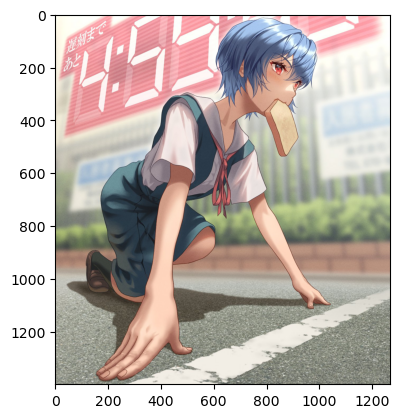

torch.Size([3, 232, 232])


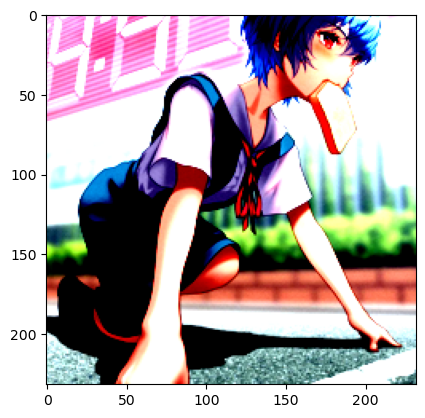

In [13]:
# 動作確認
img_path = images_path[0]
img = Image.open(img_path)
print(img.size)
plt.imshow(img)
plt.show()

size = 232
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")
print(img_transformed.shape)
# (色、高さ、幅)を(高さ、幅、色)に変化し、0－1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1) #limit (clip) the values in an array
plt.imshow(img_transformed)
plt.show()

In [14]:
# フォルダ名を取得
folder_name = os.path.basename(os.path.dirname(img_path))
print(img_path)
print(os.path.dirname(img_path))
print(folder_name)


E:\Data\mobilenet\images\ayanami_rei\02556c9a75fcf7402f4c97d340922027d17a527c.jpg
E:\Data\mobilenet\images\ayanami_rei
ayanami_rei


In [15]:

rei_imgs = get_image_filenames(os.path.dirname(img_path))

random.shuffle(rei_imgs)

# 分割比率を設定（例: 80%訓練データ、20%検証データ）
train_ratio = 0.8
total_samples = len(rei_imgs)
train_samples = int(train_ratio * total_samples)
# リストを訓練データと検証データに分割
train_data = rei_imgs[:train_samples]
val_data = rei_imgs[train_samples:]
print("Training Data Paths:", train_data)
print("Validation Data Paths:", val_data)


Training Data Paths: ['E:\\Data\\mobilenet\\images\\ayanami_rei\\ec7fe75fd9b44330442347abdaaf9666471fb0bc.png', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\a919b0526eefc730c361d0a90473592d728f6707.jpg', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\4a631fe4e88b2fcb4a69ece18a065df418c6f2c4.png', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\4825c60e001663236445d2e1207b8bee8ff89acd.jpg', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\33c19471482b03c7cf2751314817c0d7263b7cb1.jpg', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\6c60ebd15d4832fb4835a2cff5e1528a14ecbe23.png', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\f8e7d6795dcdbfb96a385699fba30a1e19de0c0e.jpg', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\e236e3547f98cefcab1270e4746339a523aa3e17.jpg', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\62a6c02b8f26de9491914d9d84779f12f07747a0.jpg', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\c14520ac36e5155c69ec1ab0a590c871f997a1e8.png', 'E:\\Data\\mobilenet\\images\\ayanami_rei\\60901dc51babac26f8433a2afb0dff065e7

In [16]:
get_image_filenames("E:\Data\mobilenet\images")

['E:\\Data\\mobilenet\\images\\ayanami_rei',
 'E:\\Data\\mobilenet\\images\\ikari_shinji',
 'E:\\Data\\mobilenet\\images\\makinami_mari_illustrious',
 'E:\\Data\\mobilenet\\images\\nagisa_kaworu',
 'E:\\Data\\mobilenet\\images\\souryuu_asuka_langley']

In [17]:
def split_train_val(images_list, train_ratio=0.8):
    """
    訓練と検証を格納したリストを作成する
    
    Parameters
    ----------
    images_list : list
        データのパスを格納したリスト
        
    Returns
    -------
    path_list : list
        データのパスを格納したリスト
    """
    
    train_paths = []
    val_paths = []
    base_dir = "E:\Data\mobilenet\images"
    # 最初はフォルダの名前を格納する
    folders_list = get_image_filenames("E:\Data\mobilenet\images")
    for folder in folders_list:
#         folder_name = os.path.basename(folder)
        paths_list = get_image_filenames(folder)

        random.shuffle(paths_list)

        # 分割比率を設定
        total_samples = len(paths_list)
        train_samples = int(train_ratio * total_samples)
        # リストを訓練データと検証データに分割
        train_data = paths_list[:train_samples]
        val_data = paths_list[train_samples:]
        
        train_paths.extend(train_data)
        val_paths.extend(val_data)
        
    return train_paths, val_paths

train_list, val_list = split_train_val(images_path)
len(train_list), len(val_list), val_list

(800,
 200,
 ['E:\\Data\\mobilenet\\images\\ayanami_rei\\944f6d06c24576165ee30ed53537a518dcc3bb99.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\e2ad2744f36070d01c0efe810398e4f565333338.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\e1d202ace37e09dcf47b662d50b50f8fd8fe1385.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\a0f010aed3199231af78dc19a4769636b50ae910.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\1ac154cee365f31d00f16b64f3cfa44795f96d94.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\003d1eefa861684c78c3f3d071887ab5bc477bfc.png',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\688c4e6249b95a113f740c8dfecd2f3733812f6f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\852c6b801f1d0ecce0fbabda0526b83ff981b6c9.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\38162dce2068ba293820ee71547b98f2e887d73b.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\a3af6c697eb153ea289db97103dc7b8a53fd9539.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\4b1f8913676726acfe1839f

In [18]:
# リストにパスを格納
def make_datapath_list(base_dir):
    """
    データのパスを格納したリストを作成する
        
    Returns
    -------
    path_list : list
        データのパスを格納したリスト
    
    """
    target_path = os.path.join(base_dir+"/*.jpg")
    print(target_path)
    
    path_list = []
    #globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list
    
make_datapath_list('E:\\Data\\mobilenet\\images\\ayanami_rei'), len(make_datapath_list('E:\\Data\\mobilenet\\images\\ayanami_rei'))

E:\Data\mobilenet\images\ayanami_rei/*.jpg
E:\Data\mobilenet\images\ayanami_rei/*.jpg


(['E:\\Data\\mobilenet\\images\\ayanami_rei\\02556c9a75fcf7402f4c97d340922027d17a527c.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\02e8f8d0b8c776844d0c09fc961aef696c88d695.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0388564845bf7eb88c4f5f19f1651ad31131442f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\05c8d268052ceb0fee405086c9f063db1664a03e.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0894fb8b55b6c082d81582df62d74bf65f7946a1.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\093d277c20cf294e6235d965b3993c02ed9e416f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0971091ad082dd8f2cd23fff4884944ddec6b2fc.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\09e7df7dd36e1f5a710547d96d284b4f2b1a5f61.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0b036ea70ddca109445b942883b4b9f8d9256e47.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0bf165f84028445bd83426b7b8edbe74a64dd808.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0e26c7d439467697ee54ffc63c75257aec1

In [19]:
def split_train_val(images_list, train_ratio=0.8):
    """
    訓練と検証を格納したリストを作成する
    
    Parameters
    ----------
    images_list : list
        データのパスを格納したリスト
        
    Returns
    -------
    path_list : list
        データのパスを格納したリスト
    """
    
    train_paths = []
    val_paths = []
    # 最初はフォルダの名前を格納する
    folders_list = get_image_filenames("E:\Data\mobilenet\images")
    for folder in folders_list:
#         folder_name = os.path.basename(folder)
        paths_list = make_datapath_list(folder)

        random.shuffle(paths_list)

        # 分割比率を設定
        total_samples = len(paths_list)
        train_samples = int(train_ratio * total_samples)
        # リストを訓練データと検証データに分割
        train_data = paths_list[:train_samples]
        val_data = paths_list[train_samples:]
        
        train_paths.extend(train_data)
        val_paths.extend(val_data)
        
    return train_paths, val_paths

base_dir = "E:\Data\mobilenet\images"
train_list, val_list = split_train_val(base_dir)
len(train_list), len(val_list), val_list


E:\Data\mobilenet\images\ayanami_rei/*.jpg
E:\Data\mobilenet\images\ikari_shinji/*.jpg
E:\Data\mobilenet\images\makinami_mari_illustrious/*.jpg
E:\Data\mobilenet\images\nagisa_kaworu/*.jpg
E:\Data\mobilenet\images\souryuu_asuka_langley/*.jpg


(625,
 159,
 ['E:\\Data\\mobilenet\\images\\ayanami_rei\\296b7f03ac1c89a86acd1eadf44a48a72b7d4282.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\5dec9ef1d9fc3523cf065d02c901999782f77299.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0b036ea70ddca109445b942883b4b9f8d9256e47.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\6951714ce4c3db3161db870688f6a82a1b6e877a.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\14fbb0cc5d35e48c61a7210291120ead8b2e25b1.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\2ac4a879ef831091f6b1c7ee4416134a97c2ae0d.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\d78db6471c3fe65f95ddb3aee548aee1b03ee123.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\b1c8ad63a9bc9dd9bff7e83c085302ad2878a965.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\88e987d1846af1b355082a1a128ceff74b334d38.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\c81e6af5819ce7c304208411cd87421addad38af.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0f0c99b0bc726ef55a0dba9

In [20]:
# エヴァンゲリオンのパイロットクラスを作成する。

class Pilots(Dataset):
    """
    エヴァンゲリオンのパイロットクラスの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """
        
    def __init__(self, file_list, labels_dict, transform=None, phase="train"):
        self.file_list = file_list
        self.transforms = transform
        self.phase = phase
        # 辞書型からラベルをエンコードする
        self.labels_dict = labels_dict
        
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''
        # テンソル型でしたら、リストに変える。
        if torch.is_tensor(index):
            index = index.tolist()
        # index番目の画像をロード
        img_path  =self.file_list[index]
        img = Image.open(img_path) # [高さ][幅][色RGB]

        
        # 画像の前処理を実施
        img_transformed = self.transforms(img, self.phase) # torch.Size([3, 232, 232])
        
        # 画像のラベルをファイル名から抜き出す
        
        # it takes the imgs one by one so it is no need for the list methods
        label = os.path.basename(os.path.dirname(img_path))
        # img_pathは一つの画像以上でしたら、ループが必要です
#         labels = []
#         for path in img_path:
#             print(path)
#             name = os.path.basename(os.path.dirname(path))
#             labels.append(name)
        #　辞書型からラベルの値を取得する、名前を値に変えて
        label = self.labels_dict[label]
        
#         for i in range(len(labels)):
#             labels[i] = self.labels_dict[labels[i]]
        
        return img_transformed, label


In [21]:
pilots_labels = {"ayanami_rei": 0, "ikari_shinji": 1, "makinami_mari_illustrious": 2,
                "nagisa_kaworu": 3, "souryuu_asuka_langley": 4}
pilots_labels["souryuu_asuka_langley"]#, pilots_labels[["souryuu_asuka_langley", "ikari_shinji"]]

4

In [22]:
# os.path.basename(os.path.dirname([  'E:\\Data\\mobilenet\\images\\nagisa_kaworu\\04a555389e1fbc4667fb560ab79d1132ef3b1ea3.jpg',
#   'E:\\Data\\mobilenet\\images\\souryuu_asuka_langley\\8189a0147298d2fa86637b75b9b37acb7eee78b9.png',]))


In [23]:
img_path = [  'E:\\Data\\mobilenet\\images\\nagisa_kaworu\\04a555389e1fbc4667fb560ab79d1132ef3b1ea3.jpg',
  'E:\\Data\\mobilenet\\images\\souryuu_asuka_langley\\8189a0147298d2fa86637b75b9b37acb7eee78b9.png',]
labels = []
for path in img_path:
    name = os.path.basename(os.path.dirname(path))
    labels.append(name)
print(labels)
#　辞書型からラベルの値を取得する、名前を値に変えて
for i in range(len(labels)):
    labels[i] = pilots_labels[labels[i]]
print(labels)

['nagisa_kaworu', 'souryuu_asuka_langley']
[3, 4]


In [24]:
size = 232
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
pilots_labels = {"ayanami_rei": 0, "ikari_shinji": 1, "makinami_mari_illustrious": 2,
                "nagisa_kaworu": 3, "souryuu_asuka_langley": 4}
# 実行
train_dataset = Pilots(
    file_list=train_list, labels_dict=pilots_labels, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = Pilots(
    file_list=val_list, labels_dict=pilots_labels, transform=ImageTransform(size, mean, std), phase='val')

# print(train_dataset[0:3])
# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])




torch.Size([3, 232, 232])
0


In [25]:
batch_size = 90

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

#動作を確認
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size(), inputs.shape)
print(labels)


torch.Size([90, 3, 232, 232]) torch.Size([90, 3, 232, 232])
tensor([0, 1, 3, 0, 0, 3, 1, 3, 1, 2, 0, 1, 2, 3, 4, 0, 4, 1, 0, 2, 3, 3, 0, 2,
        4, 1, 3, 4, 0, 1, 0, 4, 3, 3, 3, 4, 4, 1, 1, 2, 1, 3, 3, 3, 3, 0, 0, 0,
        1, 4, 1, 1, 1, 4, 0, 1, 0, 1, 3, 2, 0, 3, 1, 0, 0, 2, 2, 1, 4, 0, 2, 3,
        4, 2, 4, 3, 2, 2, 2, 1, 1, 4, 0, 0, 0, 2, 1, 4, 3, 0])


In [26]:
mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

print(mobilenet)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [27]:
#vgg－16の最後の出力層の出力ユニットをアリとハチの二つに付け替える
mobilenet.classifier[3] = nn.Linear(in_features=1280, out_features=len(pilots_labels), bias=True)
mobilenet.train()

print("ネットワーク設定完了：学習済みの重みをロードし、訓練モード設定しました")
print(mobilenet)

ネットワーク設定完了：学習済みの重みをロードし、訓練モード設定しました
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, k

In [28]:
len(pilots_labels)

5

In [29]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss(reduction="mean")

In [30]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias"]
update_param_names_3 = ["classifier.3.weight", "classifier.3.bias"]

# パラメータごとに各リストに格納する
for name, param in mobilenet.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)
    
    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)
        
    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

params_to_update_1に格納： features.0.0.weight
params_to_update_1に格納： features.0.1.weight
params_to_update_1に格納： features.0.1.bias
params_to_update_1に格納： features.1.block.0.0.weight
params_to_update_1に格納： features.1.block.0.1.weight
params_to_update_1に格納： features.1.block.0.1.bias
params_to_update_1に格納： features.1.block.1.0.weight
params_to_update_1に格納： features.1.block.1.1.weight
params_to_update_1に格納： features.1.block.1.1.bias
params_to_update_1に格納： features.2.block.0.0.weight
params_to_update_1に格納： features.2.block.0.1.weight
params_to_update_1に格納： features.2.block.0.1.bias
params_to_update_1に格納： features.2.block.1.0.weight
params_to_update_1に格納： features.2.block.1.1.weight
params_to_update_1に格納： features.2.block.1.1.bias
params_to_update_1に格納： features.2.block.2.0.weight
params_to_update_1に格納： features.2.block.2.1.weight
params_to_update_1に格納： features.2.block.2.1.bias
params_to_update_1に格納： features.3.block.0.0.weight
params_to_update_1に格納： features.3.block.0.1.weight
params_to_update

In [31]:
# 最適化手法の設定
optimizer = optim.Adam([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 3e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], weight_decay=0.001)

# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 20
    return math.pow((1-epoch/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [32]:
# モデルを学習させる関数を作成

def train_one_epoch(model, dataloaders_dict, criterion, optimizer, scheduler, device, phase, epoch):
        
    if phase == 'train':
        model.train()  # モデルを訓練モードに
        # 最適化schedulerの更新、最初のエポックは使えないすべき
        if epoch > 0:
            scheduler.step()
        optimizer.zero_grad()
        
    else:
        model.eval()   # モデルを検証モードに

    epoch_loss = 0.0  # epochの損失和
    epoch_corrects = 0  # epochの正解数        
            

    pbar = tqdm(dataloaders_dict[phase])
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        
        
        # optimizerを初期化
        optimizer.zero_grad()

        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)  # 損失を計算
            _, preds = torch.max(outputs, 1)  # ラベルを予測
            
            # 訓練時はバックプロパゲーション
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 結果の計算
            
            epoch_loss += loss.item() * imgs.size(0)  # lossの合計を更新
            # 正解数の合計を更新
            epoch_corrects += torch.sum(preds == labels.data)
        
            pbar.set_description(f"loss: {loss}")
            
    return epoch_loss, epoch_corrects

In [33]:
num_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

mobilenet = mobilenet.to(device)

for epoch in range(num_epochs):
    print("="*10)
    print(f"start {epoch+1} epochs training")
    
#     for phase in ['train', 'val']:
    phase = 'train'
    
    epoch_loss, epoch_corrects = train_one_epoch(mobilenet, dataloaders_dict, criterion, optimizer, scheduler, device, phase, epoch)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double(
    ) / len(dataloaders_dict[phase].dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    
    if epoch % 3 == 0:
        phase = 'val'
        epoch_loss, epoch_corrects = train_one_epoch(mobilenet, dataloaders_dict, criterion, optimizer, scheduler, device, phase, epoch)

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double(
        ) / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

使用デバイス： cuda:0
start 1 epochs training


loss: 1.5929617881774902:  29%|██▊       | 2/7 [00:11<00:27,  5.48s/it]C:\Users\Victor\anaconda3\envs\Torch\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (96509232 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
loss: 1.3078876733779907: 100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


train Loss: 1.4919 Acc: 0.4064


loss: 1.4737882614135742: 100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


val Loss: 1.3616 Acc: 0.3962
start 2 epochs training


loss: 0.8807690143585205: 100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


train Loss: 1.0660 Acc: 0.7088
start 3 epochs training


loss: 0.6803116202354431: 100%|██████████| 7/7 [00:40<00:00,  5.72s/it]


train Loss: 0.7055 Acc: 0.8048
start 4 epochs training


loss: 0.40665799379348755: 100%|██████████| 7/7 [00:39<00:00,  5.62s/it]


train Loss: 0.4860 Acc: 0.8352


loss: 0.9168291091918945: 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


val Loss: 0.7502 Acc: 0.7044
start 5 epochs training


loss: 0.29848775267601013: 100%|██████████| 7/7 [00:38<00:00,  5.48s/it]


train Loss: 0.3877 Acc: 0.8576
start 6 epochs training


loss: 0.20826295018196106: 100%|██████████| 7/7 [00:38<00:00,  5.51s/it]


train Loss: 0.2631 Acc: 0.9136
start 7 epochs training


loss: 0.2253076434135437: 100%|██████████| 7/7 [00:38<00:00,  5.51s/it] 


train Loss: 0.2132 Acc: 0.9216


loss: 0.6683523058891296: 100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


val Loss: 0.5957 Acc: 0.7673
start 8 epochs training


loss: 0.19785305857658386: 100%|██████████| 7/7 [00:38<00:00,  5.53s/it]


train Loss: 0.1472 Acc: 0.9536
start 9 epochs training


loss: 0.1843852549791336: 100%|██████████| 7/7 [00:38<00:00,  5.50s/it] 


train Loss: 0.1251 Acc: 0.9600
start 10 epochs training


loss: 0.08110447227954865: 100%|██████████| 7/7 [00:38<00:00,  5.56s/it]


train Loss: 0.1022 Acc: 0.9776


loss: 0.4806464910507202: 100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


val Loss: 0.4529 Acc: 0.8302
start 11 epochs training


loss: 0.07409006357192993: 100%|██████████| 7/7 [00:38<00:00,  5.53s/it]


train Loss: 0.0929 Acc: 0.9664
start 12 epochs training


loss: 0.08854617178440094: 100%|██████████| 7/7 [00:38<00:00,  5.51s/it] 


train Loss: 0.0844 Acc: 0.9728
start 13 epochs training


loss: 0.06431550532579422: 100%|██████████| 7/7 [00:38<00:00,  5.47s/it] 


train Loss: 0.0738 Acc: 0.9776


loss: 0.4811946451663971: 100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


val Loss: 0.4566 Acc: 0.8302
start 14 epochs training


loss: 0.08317001909017563: 100%|██████████| 7/7 [00:38<00:00,  5.50s/it]


train Loss: 0.0726 Acc: 0.9776
start 15 epochs training


loss: 0.020616766065359116: 100%|██████████| 7/7 [00:38<00:00,  5.54s/it]


train Loss: 0.0747 Acc: 0.9744
start 16 epochs training


loss: 0.1164662167429924: 100%|██████████| 7/7 [00:38<00:00,  5.53s/it]  


train Loss: 0.0755 Acc: 0.9728


loss: 0.5297308564186096: 100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


val Loss: 0.4523 Acc: 0.8428
start 17 epochs training


loss: 0.0497622936964035: 100%|██████████| 7/7 [00:38<00:00,  5.51s/it]  


train Loss: 0.0599 Acc: 0.9776
start 18 epochs training


loss: 0.03942472115159035: 100%|██████████| 7/7 [00:38<00:00,  5.53s/it] 


train Loss: 0.0411 Acc: 0.9824
start 19 epochs training


loss: 0.04048188030719757: 100%|██████████| 7/7 [00:38<00:00,  5.47s/it]


train Loss: 0.0539 Acc: 0.9856


loss: 0.44709092378616333: 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


val Loss: 0.3977 Acc: 0.8742
start 20 epochs training


loss: 0.022567467764019966: 100%|██████████| 7/7 [00:38<00:00,  5.51s/it]

train Loss: 0.0474 Acc: 0.9856
